In [1]:
import os
import sys

import clip
import torch
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from pathlib import Path
from PIL import Image

NOTEBOOK_DIR = os.getcwd()
sys.path.append(os.path.abspath(os.path.join(NOTEBOOK_DIR, "..")))
from search_pipeline import searcher

device = "cuda" if torch.cuda.is_available() else "cpu"

IMAGES_PATH = Path("../data/pictures") 

Some weights of RobertaModel were not initialized from the model checkpoint at ai-forever/ru-en-RoSBERTa and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Data

In [2]:
data_path = Path("../data/matching_images.txt")
data = []
with data_path.open("r") as f:
    line = f.readline()
    while line:
        sep_ind = line.find(",")
        path = "../" + line[:sep_ind]
        desc = line[sep_ind + 1:].strip().replace("\"", "")
        data.append((path, desc))
        line = f.readline()

### Cosine Similarity Testing

In [49]:
clip.available_models()

['RN50',
 'RN101',
 'RN50x4',
 'RN50x16',
 'RN50x64',
 'ViT-B/32',
 'ViT-B/16',
 'ViT-L/14',
 'ViT-L/14@336px']

We will use ResNet as backbone for CLIP, since it has similar embbedings dimention with our text encoder (1024 for ResNet, ViT has 512)

In [55]:
resnet50, preprocess_resnet50 = clip.load("RN50", device=device)

In [ ]:
def get_embs(model, preprocess, data):
    image_embs = []
    text_embs = []

    for image_path, image_desc in tqdm(data):
        image = preprocess(Image.open(image_path)).unsqueeze(0).to(device)
        text = image_desc

        with torch.no_grad():
            encoded_image = model.encode_image(image)
            encoded_text = searcher.encode_strings([text])
            
            image_embs.append(encoded_image)
            text_embs.append(torch.from_numpy(encoded_text))

    image_embs = torch.stack(image_embs).squeeze()
    text_embs = torch.stack(text_embs).squeeze()

    return image_embs, text_embs

In [ ]:
image_embs, text_embs = get_embs(resnet50, preprocess_resnet50, data)
cos_sims = F.cosine_similarity(image_embs.squeeze(), text_embs.squeeze())

print(f"mean: {cos_sims.mean():.4f}")
print(f"std: {cos_sims.std():.4f}")
print(f"min: {cos_sims.min():.4f}")
print(f"max: {cos_sims.max():.4f}")

mean: 0.0169
std: 0.0247
min: -0.0404
max: 0.0777


Seems like english words are not good for our text encoder. Let's try translating them

In [6]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

tokenizer = AutoTokenizer.from_pretrained("Helsinki-NLP/opus-mt-en-ru")
translator_model = AutoModelForSeq2SeqLM.from_pretrained("Helsinki-NLP/opus-mt-en-ru")

source.spm:   0%|          | 0.00/803k [00:00<?, ?B/s]

target.spm:   0%|          | 0.00/1.08M [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

/home/artem/anaconda3/envs/search/lib/python3.12/site-packages/transformers/models/marian/tokenization_marian.py:175: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")


pytorch_model.bin:   0%|          | 0.00/307M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/293 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/307M [00:00<?, ?B/s]

In [15]:
translated_data = []
for image, text in tqdm(data):
    tokens = tokenizer(text, return_tensors="pt")
    translated_text = translator_model.generate(**tokens)
    translated_text = tokenizer.decode(translated_text[0], skip_special_tokens=True)
    translated_data.append((image, translated_text))

100%|██████████| 311/311 [02:59<00:00,  1.73it/s]


In [17]:
translated_data[:5]

[('../data/pictures/1.jpg',
  'Женская бежевая пальто деми-сезона, женская джинсовая куртка'),
 ('../data/pictures/2.jpg',
  'Женское летнее платье с синим отпечатком и короткими рукавами, женская юбка с цветочным отпечатком, женская солнечная одежда с ремнями'),
 ('../data/pictures/3.jpg',
  'Костюм бирюзовой женщины, состоящий из блузки и юбки, фиолетового женского платья, черного женского платья.'),
 ('../data/pictures/4.jpg', 'Женские бежевые бежевые, серые и черные'),
 ('../data/pictures/5.jpg', 'Женские джинсы синего и черного цвета')]

In [56]:
image_embs, text_embs = get_embs(resnet50, preprocess_resnet50, translated_data)
cos_sims = F.cosine_similarity(image_embs.squeeze(), text_embs.squeeze())

print(f"mean: {cos_sims.mean():.4f}")
print(f"std: {cos_sims.std():.4f}")
print(f"min: {cos_sims.min():.4f}")
print(f"max: {cos_sims.max():.4f}")

100%|██████████| 311/311 [01:44<00:00,  2.97it/s]

mean: 0.0151
std: 0.0252
min: -0.0596
max: 0.0820


It still can't show high cosine similarity, but let's not focus on this and see what we actually have

### Search Testing

In [45]:
def find_image(request, image_embs):
    text_emb = torch.from_numpy(searcher.encode_strings([request]))
    images = F.cosine_similarity(text_emb, image_embs).squeeze()
    return torch.argsort(images, descending=True)

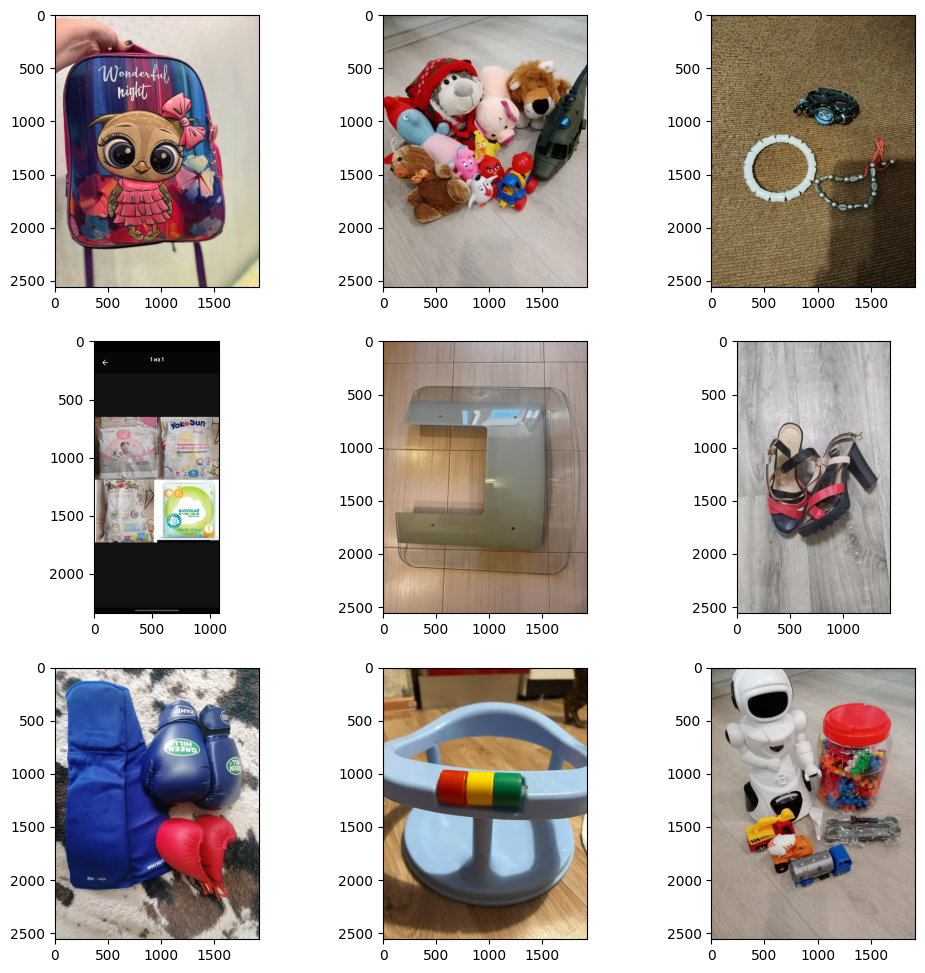

In [99]:
indices = find_image("бежевое пальто", image_embs).squeeze().tolist()
images = [data[i][0] for i in indices]

fig, ax = plt.subplots(3, 3, figsize=(12, 12))
for i, image in enumerate(images[:9]):
    img = Image.open(image)
    ax[i // 3][i % 3].imshow(img)
plt.show()

Looks like there are no beige coats. Possible reasons for this:
1) Bad image encoder
2) Bad text encoder
3) Launguage difference, CLIP was trained on pairs of images and english texts, therefore russian text encoder can be not "suitable" for CLIP

The third reason seems most possible. Since russian and english languages have few in common (in both grammar and vocabulary), text encoder, trained on one of languages, can't show any quality on the other one. Let's test this theory.

### Full CLIP Pipeline 

In [66]:
def get_clip_embs(model, preprocess, data):
    image_embs = []
    text_embs = []

    for image_path, image_desc in tqdm(data):
        image = preprocess(Image.open(image_path)).unsqueeze(0).to(device)
        text = clip.tokenize(image_desc, truncate=True).to(device)

        with torch.no_grad():
            encoded_image = model.encode_image(image)
            encoded_text = model.encode_text(text)
            
            image_embs.append(encoded_image)
            text_embs.append(encoded_text)

    image_embs = torch.stack(image_embs).squeeze()
    text_embs = torch.stack(text_embs).squeeze()

    return image_embs, text_embs

In [63]:
image_embs, text_embs = get_clip_embs(resnet50, preprocess_resnet50, data)
cos_sims = F.cosine_similarity(image_embs.squeeze(), text_embs.squeeze())

print(f"mean: {cos_sims.mean():.4f}")
print(f"std: {cos_sims.std():.4f}")
print(f"min: {cos_sims.min():.4f}")
print(f"max: {cos_sims.max():.4f}")

100%|██████████| 311/311 [00:54<00:00,  5.72it/s]

mean: 0.2380
std: 0.0344
min: 0.0796
max: 0.3093


Looks like the theory is right. We reached significant increase in the average cosine similarity. Now let's try this with russian

In [67]:
image_embs, text_embs = get_clip_embs(resnet50, preprocess_resnet50, translated_data)
cos_sims = F.cosine_similarity(image_embs.squeeze(), text_embs.squeeze())

print(f"mean: {cos_sims.mean():.4f}")
print(f"std: {cos_sims.std():.4f}")
print(f"min: {cos_sims.min():.4f}")
print(f"max: {cos_sims.max():.4f}")

100%|██████████| 311/311 [00:52<00:00,  5.96it/s]

mean: 0.1605
std: 0.0199
min: 0.1094
max: 0.2724


Seems like we actually can use russian, but there is loss in quality. But it's still better than our previous solution. However numbers are numbers, let's see if it can actually find us something

In [94]:
def find_image_clip(request, image_embs, model):
    text_tokens = clip.tokenize(request, truncate=True)
    with torch.no_grad():
        text_emb = model.encode_text(text_tokens)
    
    images = F.cosine_similarity(text_emb, image_embs).squeeze()
    return torch.argsort(images, descending=True)

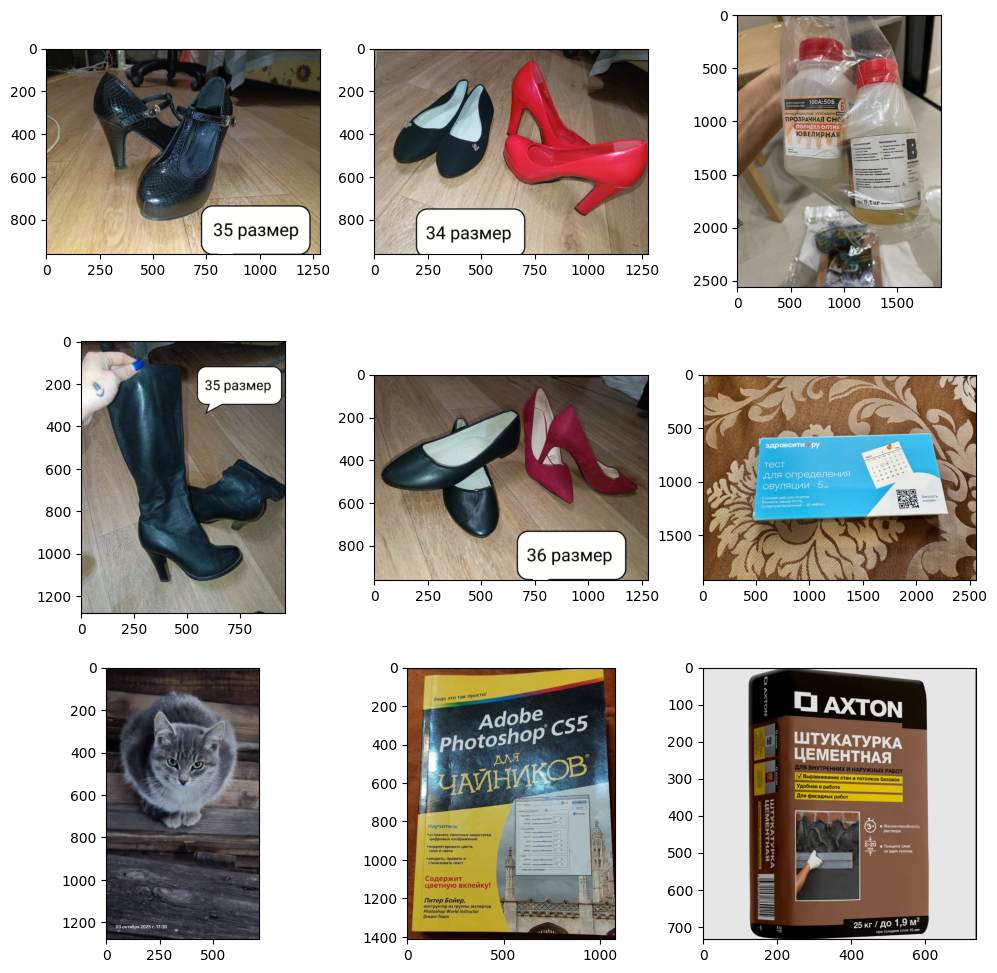

In [102]:
indices = find_image_clip("собака", image_embs, resnet50).squeeze().tolist()
images = [data[i][0] for i in indices]

fig, ax = plt.subplots(3, 3, figsize=(12, 12))
for i, image in enumerate(images[:9]):
    img = Image.open(image)
    ax[i // 3][i % 3].imshow(img)
plt.show()

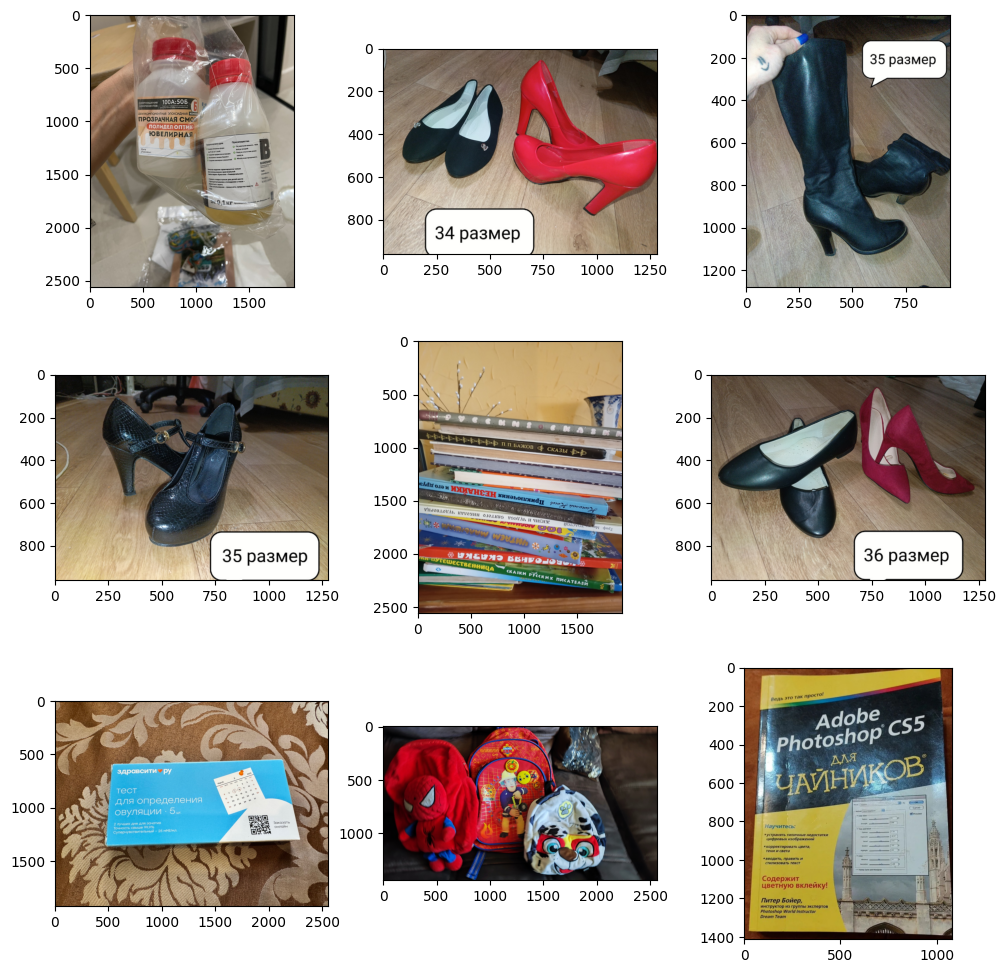

In [103]:
indices = find_image_clip("бежевое пальто", image_embs, resnet50).squeeze().tolist()
images = [data[i][0] for i in indices]

fig, ax = plt.subplots(3, 3, figsize=(12, 12))
for i, image in enumerate(images[:9]):
    img = Image.open(image)
    ax[i // 3][i % 3].imshow(img)
plt.show()

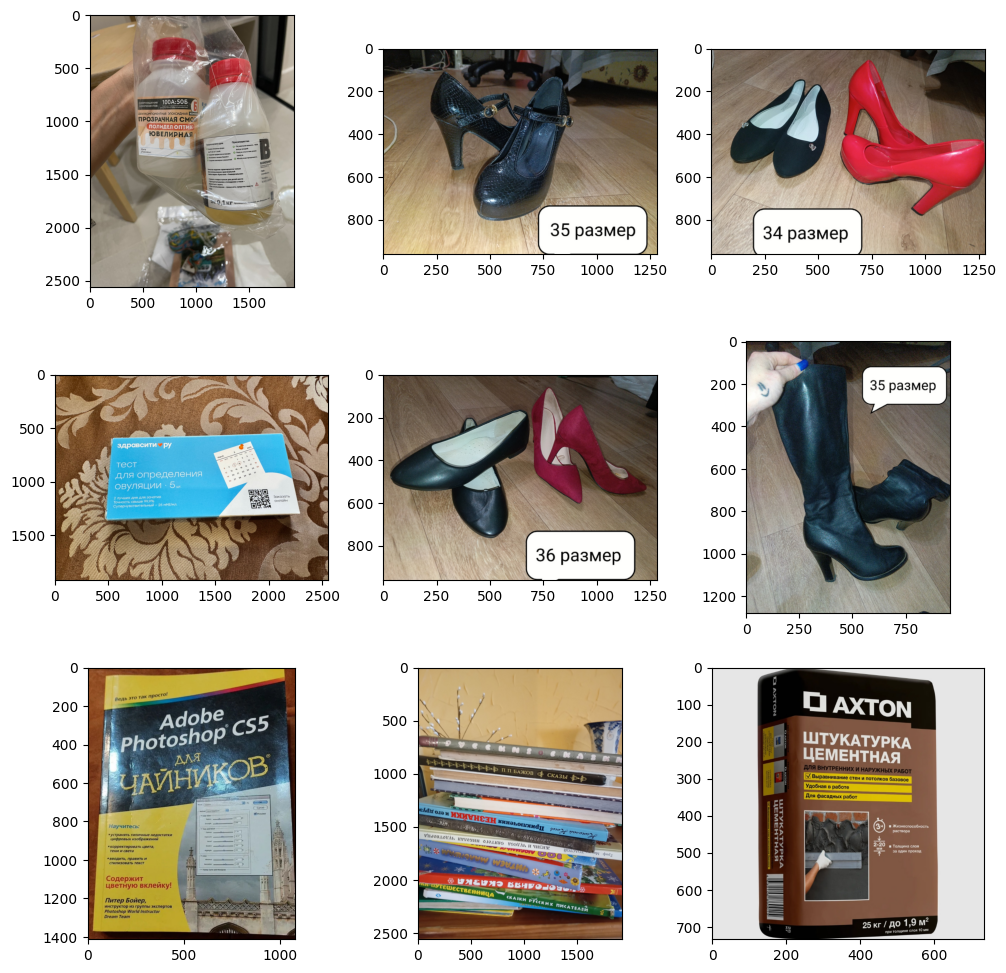

In [105]:
indices = find_image_clip("растение в горшке", image_embs, resnet50).squeeze().tolist()
images = [data[i][0] for i in indices]

fig, ax = plt.subplots(3, 3, figsize=(12, 12))
for i, image in enumerate(images[:9]):
    img = Image.open(image)
    ax[i // 3][i % 3].imshow(img)
plt.show()

Looks like we have the same answers on every question. Let's investigate that...

In [127]:
russian_tokens1 = clip.tokenize(["собака", "бежевое пальто", "растение в горшке"])
russian_tokens2 = clip.tokenize(["антрисоль", "садовый шланг", "салфетки"])


with torch.no_grad():
    english_encoded = resnet50.encode_text(russian_tokens1)
    russian_encoded = resnet50.encode_text(russian_tokens2)
    print(F.cosine_similarity(english_encoded, russian_encoded))

tensor([0.9351, 0.9080, 0.8916])


Looks like "собака" and "антрисоль" have a lot in common... So, that's the answer - every russain text will encode in similar vectors in linear space, that are so far away from image embbeings in the same space, that compairing with them makes the results that we can see above

And yes, it works just fine with english texts:

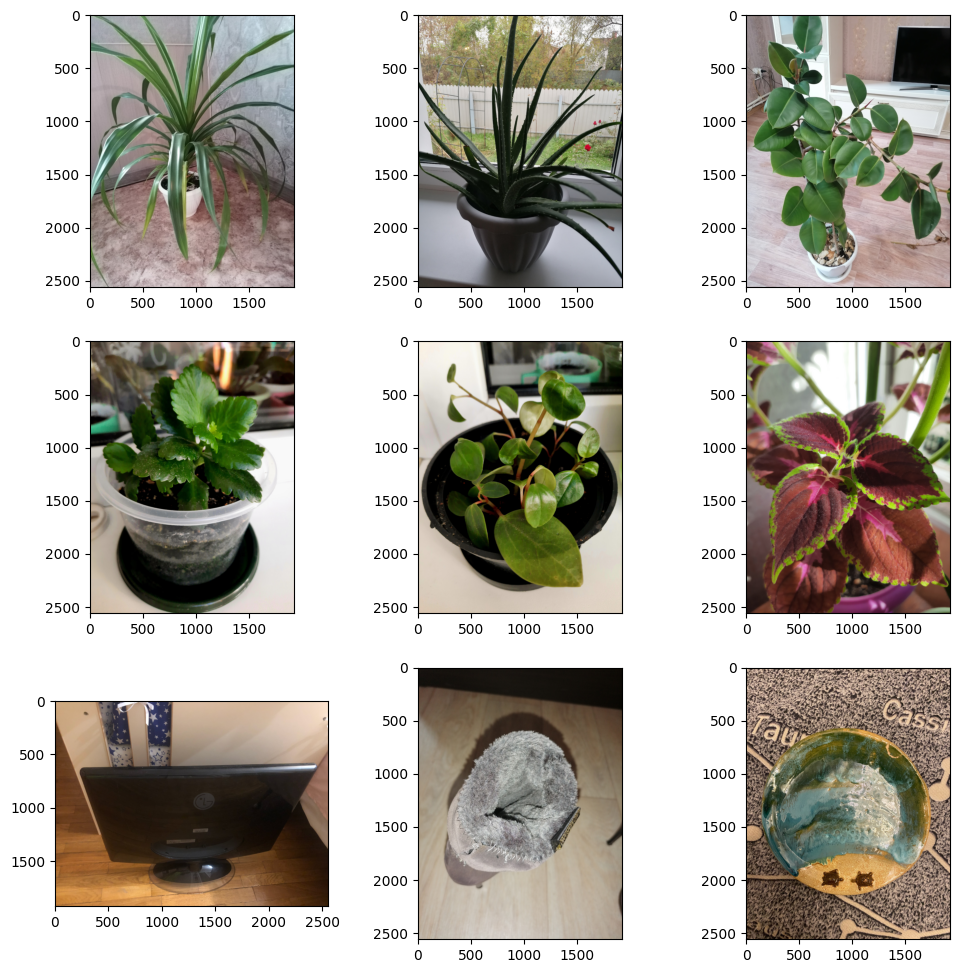

In [128]:
indices = find_image_clip("a plant in a pot", image_embs, resnet50).squeeze().tolist()
images = [data[i][0] for i in indices]

fig, ax = plt.subplots(3, 3, figsize=(12, 12))
for i, image in enumerate(images[:9]):
    img = Image.open(image)
    ax[i // 3][i % 3].imshow(img)
plt.show()

---

So, what we have. For image encoding we have only CLIP, but for text we have some options

Text encoding  | CLIP (english) | CLIP (russian) | Ours
---------------|----------------|----------------|------
Search Quality |      Good      |      Bad       | Bad

Therefore, the solutions here:
1) Translate requests to english: we must have translation model 
2) Finetune CLIP for russian texts: quite difficult, since it requires data, resources and time
3) Find something similar to CLIP, but for russian texts: if there any, it's the best option. And it seems like we actually have something: https://github.com/ai-forever/ru-clip. But there is a problem - dependencies. `Sentence transformers` lib require `huggingface-hub>=0.36.0` and `ruclip` needs `huggingface-hub<0.26.0`. May be there is a way to use it from `transformers` lib, but I haven't found it yet.

---